# MRI Görüntülerinden Beyin Tümörü Sınıflandırması

## Derin Öğrenme (FET312) - Proje Kod Dosyası

* **Grup Adı:** DevTe213
* **Öğrenci:** Arda Ölmez
* **Model Stratejisi:** Deeper Model (Derinlik Varyasyonu)
* **Açıklama:** Bu notebook, standart sığ CNN modellerine kıyasla katman sayısını artırmanın (2 bloktan 3 bloğa çıkmanın) modelin öznitelik hiyerarşisini öğrenme üzerindeki etkisini analiz etmek amacıyla hazırlanmıştır.
* **Veri Seti:** Sartaj Bhuvaji (Kaggle) - Brain Tumor Classification (MRI)
  * 4 Sınıf: Glioma, Meningioma, Pituitary, No Tumor

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- TEKRARLANABİLİRLİK İÇİN SEED AYARI ---
SEED = 213
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Cihaz Seçimi (GPU varsa kullan)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

Kullanılan Cihaz: cuda


In [3]:
# --- HİPER-PARAMETRELER ---
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 15

DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-1\training" 

# Veri Dönüşümleri (Pipeline)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 128x128 Boyutlandırma
    transforms.ToTensor(),                   # Tensör Dönüşümü
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalizasyon
])

try:
    # Veri setini klasörden yükle
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
    print(f"Toplam Görüntü Sayısı: {len(full_dataset)}")
    print(f"Sınıflar: {full_dataset.classes}")
    
    # Train (%70) - Val (%15) - Test (%15) Ayrımı
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    
    # DataLoader Tanımlama
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print("Veri setleri başarıyla ayrıştırıldı ve yüklendi.")
    
except Exception as e:
    print(f"HATA: Veri yolu bulunamadı veya hatalı! Lütfen 'DATA_PATH' değişkenini kontrol edin.\nHata Detayı: {e}")

Toplam Görüntü Sayısı: 2870
Sınıflar: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Veri setleri başarıyla ayrıştırıldı ve yüklendi.


In [4]:
class DeeperBrainTumorModel(nn.Module):
    def __init__(self):
        super(DeeperBrainTumorModel, self).__init__()
        
        # --- BLOK 1 ---
        # Giriş: 3 Kanal (RGB) -> Çıkış: 16 Filtre
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Boyut: 128 -> 64
        
        # --- BLOK 2 ---
        # Giriş: 16 -> Çıkış: 32 Filtre
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Boyut: 64 -> 32
        
        # --- BLOK 3 (ARDA ÖLMEZ FARKI) ---
        # Ekstra derinlik katmanı. Giriş: 32 -> Çıkış: 64 Filtre
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Boyut: 32 -> 16
        
        # --- SINIFLANDIRMA KATMANI ---
        # Flatten sonrası boyut hesabı:
        # Son görüntü boyutu: 16x16. Son kanal sayısı: 64.
        # Toplam nöron: 64 * 16 * 16 = 16384
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 4) # 4 Sınıf Çıkışı

    def forward(self, x):
        # Blok 1
        x = self.pool1(self.relu1(self.conv1(x)))
        # Blok 2
        x = self.pool2(self.relu2(self.conv2(x)))
        # Blok 3 (Ekstra Katman)
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten ve Dense
        x = self.flatten(x)
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

# Modeli Başlat
model = DeeperBrainTumorModel().to(DEVICE)
print("Arda Ölmez - Deeper Model (3-Blok) başarıyla oluşturuldu.")
# Model özeti (Katmanları görmek için)
print(model)

Arda Ölmez - Deeper Model (3-Blok) başarıyla oluşturuldu.
DeeperBrainTumorModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu_fc): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [4]:
# Loss ve Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Grafik için listeler
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"Eğitim Başlıyor... ({EPOCHS} Epoch)")

for epoch in range(EPOCHS):
    # --- TRAIN MODU ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    
    # --- VALIDATION MODU ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    
    # Listelere Kayıt
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {epoch_train_loss:.4f} - Acc: %{epoch_train_acc:.2f} | "
          f"Val Loss: {epoch_val_loss:.4f} - Acc: %{epoch_val_acc:.2f}")

print("Eğitim Tamamlandı.")

Eğitim Başlıyor... (15 Epoch)
Epoch [1/15] | Train Loss: 0.9759 - Acc: %59.31 | Val Loss: 0.6943 - Acc: %68.14
Epoch [2/15] | Train Loss: 0.6311 - Acc: %73.66 | Val Loss: 0.5540 - Acc: %78.37
Epoch [3/15] | Train Loss: 0.4585 - Acc: %81.47 | Val Loss: 0.5411 - Acc: %77.67
Epoch [4/15] | Train Loss: 0.3207 - Acc: %87.75 | Val Loss: 0.4018 - Acc: %85.35
Epoch [5/15] | Train Loss: 0.2193 - Acc: %91.73 | Val Loss: 0.4104 - Acc: %85.12
Epoch [6/15] | Train Loss: 0.1732 - Acc: %94.12 | Val Loss: 0.4648 - Acc: %85.58
Epoch [7/15] | Train Loss: 0.1121 - Acc: %95.82 | Val Loss: 0.5094 - Acc: %85.58
Epoch [8/15] | Train Loss: 0.0759 - Acc: %97.76 | Val Loss: 0.4815 - Acc: %87.44
Epoch [9/15] | Train Loss: 0.0517 - Acc: %98.36 | Val Loss: 0.5154 - Acc: %88.14
Epoch [10/15] | Train Loss: 0.0572 - Acc: %98.16 | Val Loss: 0.5286 - Acc: %88.84
Epoch [11/15] | Train Loss: 0.0233 - Acc: %99.60 | Val Loss: 0.5365 - Acc: %87.44
Epoch [12/15] | Train Loss: 0.0125 - Acc: %99.75 | Val Loss: 0.5111 - Acc: %8

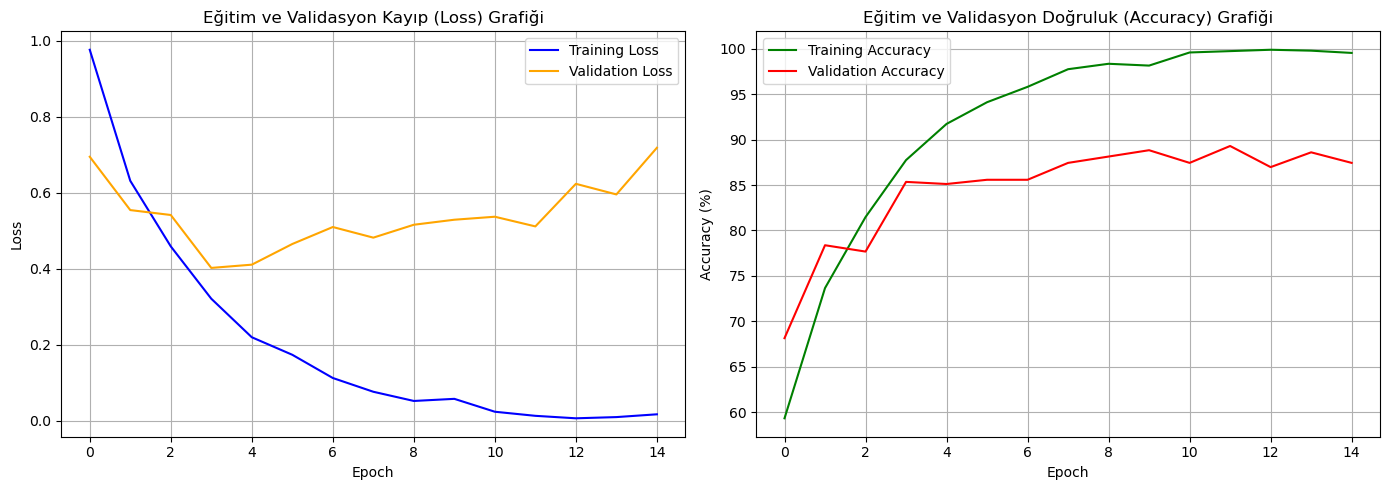

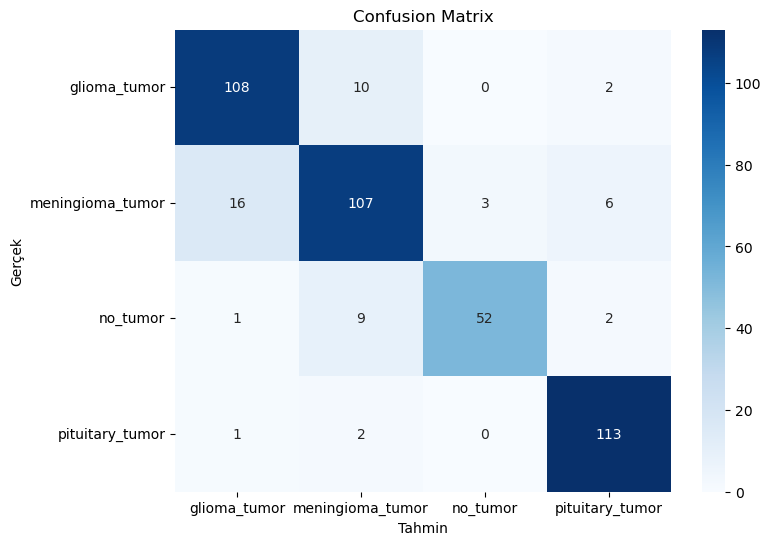


--- SINIFLANDIRMA RAPORU ---

                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.90      0.88       120
meningioma_tumor       0.84      0.81      0.82       132
        no_tumor       0.95      0.81      0.87        64
 pituitary_tumor       0.92      0.97      0.95       116

        accuracy                           0.88       432
       macro avg       0.89      0.87      0.88       432
    weighted avg       0.88      0.88      0.88       432



In [6]:
# Grafik Çizimi (Loss ve Accuracy Yan Yana)
plt.figure(figsize=(14, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Eğitim ve Validasyon Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.title('Eğitim ve Validasyon Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TEST VE CONFUSION MATRIX
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

classes = full_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

print("\n--- SINIFLANDIRMA RAPORU ---\n")
print(classification_report(all_labels, all_preds, target_names=classes))